In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [25]:
#Cargo datos de entrada
lentes = pd.read_csv(r"lenses.data")
#ATRIBUTOS
#1. age of the patient: (1) young, (2) pre-presbyopic, (3) presbyopic  
#2. spectacle prescription:  (1) myope, (2) hypermetrope  
#3. astigmatic:     (1) no, (2) yes  
#4. tear production rate:  (1) reduced, (2) normal
#CLASE
#1. hard contact lenses
#2. soft contact lenses
#3. no contact lenses

In [47]:
#Filas, columnas
lentes.shape
lentes = lentes.drop('nro', axis = 1)

KeyError: "['nro'] not found in axis"

In [48]:
#Veo primeras filas
lentes.head()

,age,spectacle,astigmatic,rate,class
0,1,1,1,1,3
1,1,1,1,2,2
2,1,1,2,1,3
3,1,1,2,2,1
4,1,2,1,1,3


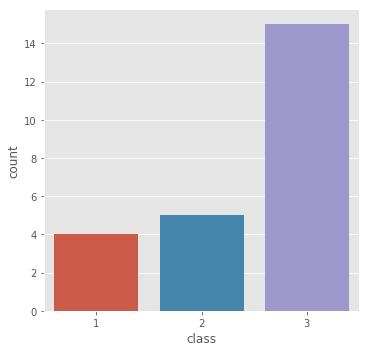

In [49]:
#Grafico class
lentes.groupby('class').size()
sb.catplot('class',data=lentes,kind="count")

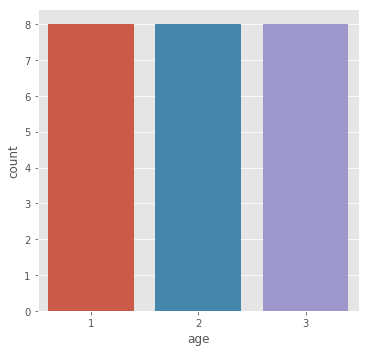

In [50]:
#Grafico age
lentes.groupby('age').size()
sb.catplot('age',data=lentes,kind="count")

In [51]:
lentes.describe()

,age,spectacle,astigmatic,rate,class
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2.000000,1.500000,1.500000,1.500000,2.458333
std,0.834058,0.510754,0.510754,0.510754,0.779028
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000
50%,2.000000,1.500000,1.500000,1.500000,3.000000
75%,3.000000,2.000000,2.000000,2.000000,3.000000
max,3.000000,2.000000,2.000000,2.000000,3.000000


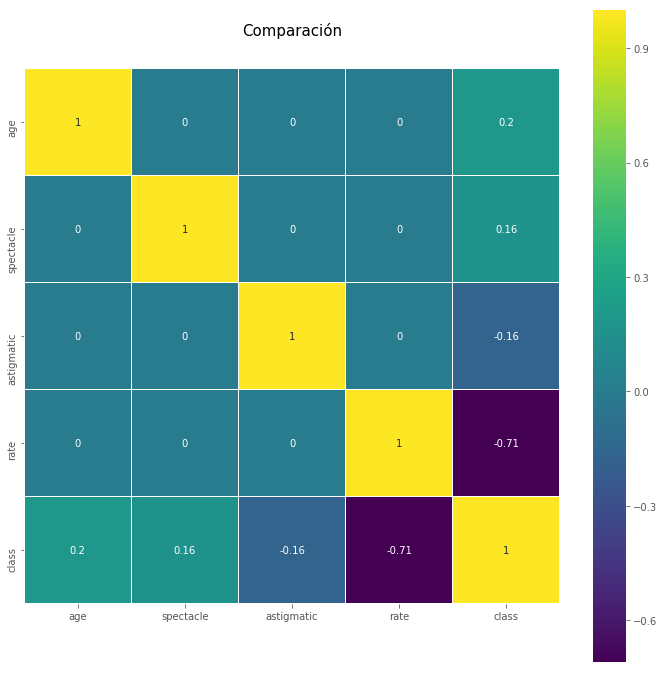

In [52]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Comparación', y=1.05, size=15)
sb.heatmap(lentes.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [99]:
#Buscamos la profundidad para nuestro árbol de decisión
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(lentes))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',#ó podría ser gini
                                             min_samples_split=2,#se refiere a la cantidad mínima de muestras que debe tener un nodo para poder subdividir.
                                             min_samples_leaf=1,#cantidad mínima que puede tener una hoja final. Si tuviera menos, no se formaría esa hoja y “subiría” un nivel, su antecesor.
                                             max_depth = depth,
                                            #class_weight: las opciones son 1, 2 o 3
                                            #Tengo muchos 3, algunos 2 y pocos 1
                                            #Por lo que modifico el peso para compensar
                                            #Hay 24 valors, 4 tienen 1, 5 tienen 2 y 15 tienen 3
                                            #al 1 le pongo de peso: 15/4=3.75
                                            #al 2 le pongo de peso: 15/5=3                                             
                                             class_weight={1:3.75, 2:3}
                                            )
    for train_fold, valid_fold in cv.split(lentes):
        f_train = lentes[train_fold[0]:train_fold[len(train_fold)-1]] 
        f_valid = lentes[valid_fold[0]:valid_fold[len(valid_fold)-1]] 

        model = tree_model.fit(X = f_train.drop(['class'], axis=1), 
                               y = f_train["class"]) 
        valid_acc = model.score(X = f_valid.drop(['class'], axis=1), 
                                y = f_valid["class"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1               0.2
         2               1.0
         3               1.0
         4               1.0
         5               1.0


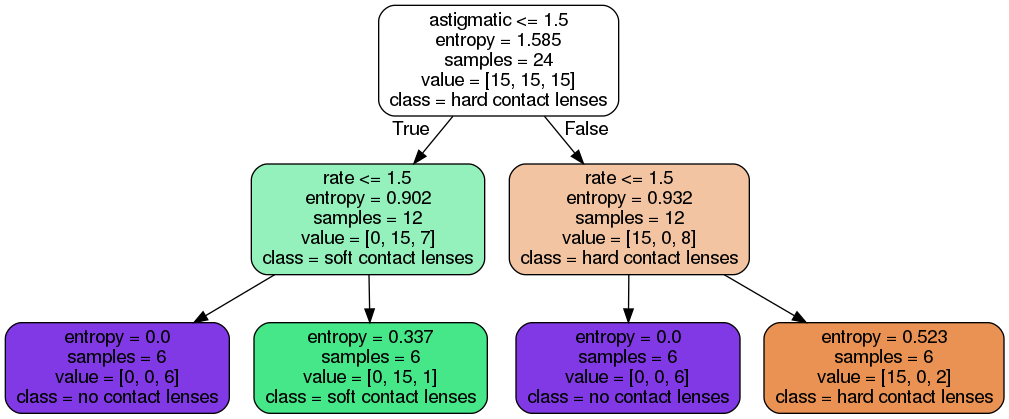

In [101]:
#En 2 nivel tenemos el porcentaje mas alto

# Crear arrays de entrenamiento
y_train = lentes['class']
x_train = lentes.drop(['class'], axis=1).values 
 
# Crear Arbol de decision con profundidad = 2
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',#ó podría ser gini
                                             min_samples_split=2,#se refiere a la cantidad mínima de muestras que debe tener un nodo para poder subdividir.
                                             min_samples_leaf=1,#cantidad mínima que puede tener una hoja final. Si tuviera menos, no se formaría esa hoja y “subiría” un nivel, su antecesor.
                                            max_depth = 2,
                                            #class_weight: las opciones son 1, 2 o 3
                                            #Tengo muchos 3, algunos 2 y pocos 1
                                            #Por lo que modifico el peso para compensar
                                            #Hay 24 valors, 4 tienen 1, 5 tienen 2 y 15 tienen 3
                                            #al 1 le pongo de peso: 15/4=3.75
                                            #al 2 le pongo de peso: 15/5=3
                                            class_weight={1:3.75, 2:3}
                                           )
decision_tree.fit(x_train, y_train)
 
# exportar el modelo a archivo .dot
with open(r"lenses_tree.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 2,
                              impurity = True,
                              feature_names = list(lentes.drop(['class'], axis=1)),
                              class_names = ['hard contact lenses','soft contact lenses','no contact lenses'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
import subprocess
#Si no tenemos graphviz
#subprocess.call("sudo apt install graphviz",shell=True)
#Creamos png desde dot
subprocess.call("dot -Tpng lenses_tree.dot -o lenses_tree.png",shell=True)
PImage("lenses_tree.png")